In [2]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Base path for data
BASE = '../data/'

In [3]:
# Step 1: Load Data
product_data = pd.read_csv(BASE + 'products.csv')
edges_data = pd.read_csv(BASE + 'edges.csv')

# Clean the data
product_data_clean = product_data.dropna(subset=['average_rating', 'num_reviews', 'salesrank'])
product_data_clean['average_rating'] = pd.to_numeric(product_data_clean['average_rating'], errors='coerce')
product_data_clean['num_reviews'] = pd.to_numeric(product_data_clean['num_reviews'], errors='coerce')
product_data_clean['salesrank'] = pd.to_numeric(product_data_clean['salesrank'], errors='coerce')
product_data_clean = product_data_clean.dropna(subset=['average_rating', 'num_reviews', 'salesrank'])


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/3702903549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data_clean['average_rating'] = pd.to_numeric(product_data_clean['average_rating'], errors='coerce')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/3702903549.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data_clean['num_reviews'] = pd.to_numeric(product_data_clean['num_reviews'], errors='coerce')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn

In [4]:
# Step 2: Create the Graph for Bundles (Co-purchase Relationships)
G = nx.Graph()
for _, row in edges_data.iterrows():
    G.add_edge(row['source'], row['target'])

# Find connected components (i.e., bundles of products frequently bought together)
bundles = list(nx.connected_components(G))

In [5]:
# Step 3: Create Bundle Features
bundle_features = []
bundle_revenue_scores = []

# Create a mapping from ASIN to product metadata for easy lookup
product_metadata = product_data_clean.set_index('ASIN').to_dict(orient='index')

valid_bundles = []

# Loop over each bundle to create features
for bundle in bundles:
    known_asins = [asin for asin in bundle if asin in product_metadata]
    num_known = len(known_asins)
    num_total = len(bundle)
    
    # Skip bundle if less than 80% of products are known
    if num_total == 0 or num_known / num_total < 0.8:
        continue

    bundle_salesrank = 0
    bundle_num_reviews = 0
    bundle_avg_rating = 0
    
    for asin in known_asins:
        product = product_metadata[asin]
        bundle_salesrank += product['salesrank']
        bundle_num_reviews += product['num_reviews']
        bundle_avg_rating += product['average_rating']
    
    bundle_avg_rating /= num_known
    bundle_salesrank /= num_known
    bundle_num_reviews /= num_known

    if bundle_salesrank != 0:
        revenue_score = (bundle_num_reviews * bundle_avg_rating) / bundle_salesrank
    else:
        revenue_score = 0

    bundle_features.append([bundle_salesrank, bundle_num_reviews, bundle_avg_rating, num_known])
    bundle_revenue_scores.append(revenue_score)
    valid_bundles.append(known_asins)

# Convert bundle features and revenue scores into a DataFrame
df_bundles = pd.DataFrame(bundle_features, columns=['avg_salesrank', 'avg_num_reviews', 'avg_rating', 'bundle_size'])
df_bundles['revenue_score'] = bundle_revenue_scores

In [6]:
# Step 4: Split Data for Training and Testing
X = df_bundles[['avg_salesrank', 'avg_num_reviews', 'avg_rating', 'bundle_size']]
y = df_bundles['revenue_score']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output Results
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

feature_importances = model.feature_importances_
print(f"Feature Importances: {dict(zip(X.columns, feature_importances))}")

# Save the model and the processed data (optional)
df_bundles.to_csv(BASE + 'bundles.csv', index=False)


RMSE: 0.0012
R² Score: 0.5774
Feature Importances: {'avg_salesrank': np.float64(0.6008491225056702), 'avg_num_reviews': np.float64(0.37973135211927583), 'avg_rating': np.float64(0.0075224784677519274), 'bundle_size': np.float64(0.011897046907301983)}


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/3899133954.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


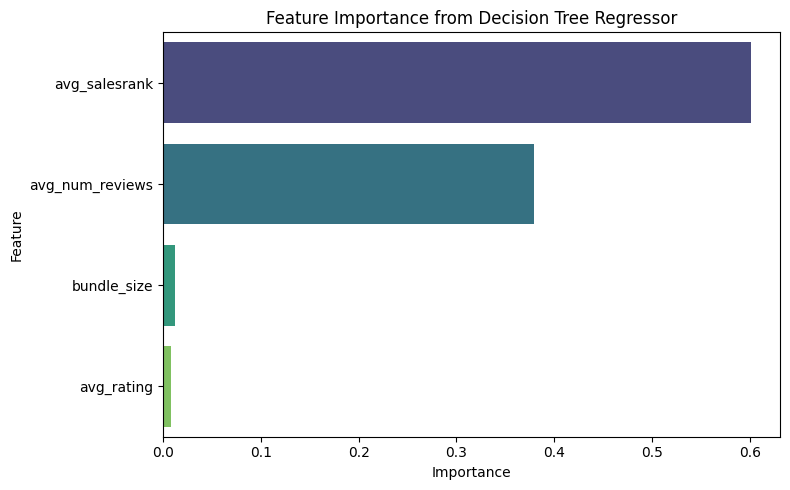

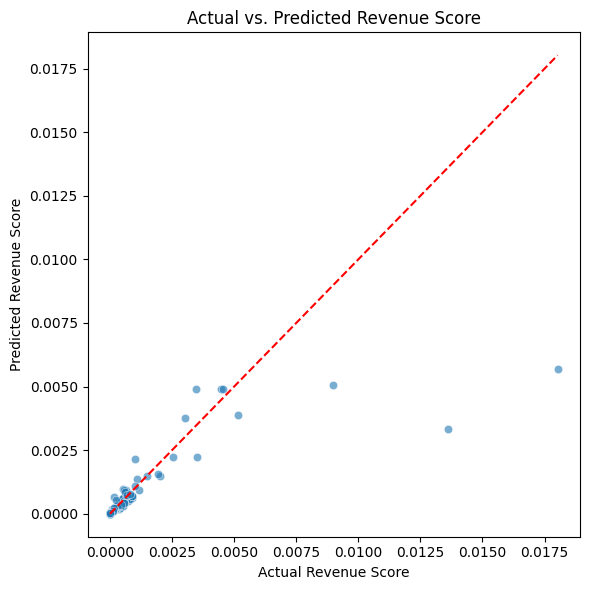


Top 5 Bundle Recommendations:

Bundle #532
Revenue Score: 0.02
Average Rating: 4.31, Reviews: 166, Sales Rank: 39747
Products:
 - The Distance to Here
 - V
 - Mental Jewelry
 - Birds of Pray (Bonus DVD)
 - Secret Samadhi
 - Birds of Pray
 - Throwing Copper
 - Throwing Copper [Bonus Disc]

Bundle #266
Revenue Score: 0.01
Average Rating: 4.29, Reviews: 75, Sales Rank: 23616
Products:
 - Pokemon -  The Movie 2000
 - Pokemon - Mewtwo Returns
 - Pokemon - Mewtwo Returns
 - Pokemon - Mewtwo Returns
 - Pokemon Movie Collection  (The First Movie/The Movie 2000/Pokemon 3)
 - Pokemon 3 - The Movie
 - Pokémon 4Ever
 - Pokémon 4Ever
 - Pokemon 3 - The Movie
 - Pokemon 3 - The Movie
 - Pokemon the First Movie: Mewtwo vs. Mew
 - Pokemon Movie Collection  (The First Movie/The Movie 2000/Pokemon 3)
 - Pokemon - The Movie 2000
 - Pokemon the First Movie - Mewtwo vs. Mew

Bundle #40
Revenue Score: 0.01
Average Rating: 4.50, Reviews: 15, Sales Rank: 7568
Products:
 - Wee Sing:  Under the Sea
 - Wee Sing

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd

# -----------------------------
# Step 0: Ensure Valid Bundle List Used
# -----------------------------

# Set the valid ASIN list in the same order as df_bundles
df_bundles['ASIN_list'] = valid_bundles

# -----------------------------
# Step 1: Enhance Bundle Data with Titles
# -----------------------------

# Map ASINs to product titles using the same cleaned dataset used in modeling
asin_to_title = product_data_clean.set_index('ASIN')['title'].to_dict()

def get_titles(asins):
    return [asin_to_title.get(asin, 'Unknown') for asin in asins]

# Add product titles to df_bundles
df_bundles['product_titles'] = df_bundles['ASIN_list'].apply(get_titles)

# Sort bundles by revenue_score (descending)
top_bundles = df_bundles.sort_values(by='revenue_score', ascending=False)

# Save top bundles to CSV
top_bundles.to_csv(BASE + 'top_bundles.csv', index=False)

# -----------------------------
# Step 2: Visualize Feature Importance
# -----------------------------
plt.figure(figsize=(8, 5))

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Barplot for feature importance
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Decision Tree Regressor')
plt.tight_layout()
plt.savefig(BASE + 'feature_importance.png')
plt.show()

# -----------------------------
# Step 3: Predicted vs Actual Plot
# -----------------------------
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Revenue Score')
plt.ylabel('Predicted Revenue Score')
plt.title('Actual vs. Predicted Revenue Score')
plt.tight_layout()
plt.savefig(BASE + 'regression_scatter.png')
plt.show()

# -----------------------------
# Step 4: Print Top 5 Bundle Recommendations
# -----------------------------
print("\nTop 5 Bundle Recommendations:")
for idx, row in top_bundles.head(5).iterrows():
    print(f"\nBundle #{idx + 1}")
    print(f"Revenue Score: {row['revenue_score']:.2f}")
    print(f"Average Rating: {row['avg_rating']:.2f}, Reviews: {int(row['avg_num_reviews'])}, Sales Rank: {int(row['avg_salesrank'])}")
    print("Products:")
    for title in row['product_titles']:
        print(f" - {title}")



--- Characterizing Bundle Performance Tiers ---


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/318531879.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bundles, x='performance_tier', y=feature, order=tier_order, palette='viridis')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/318531879.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bundles, x='performance_tier', y=feature, order=tier_order, palette='viridis')
/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/318531879.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s

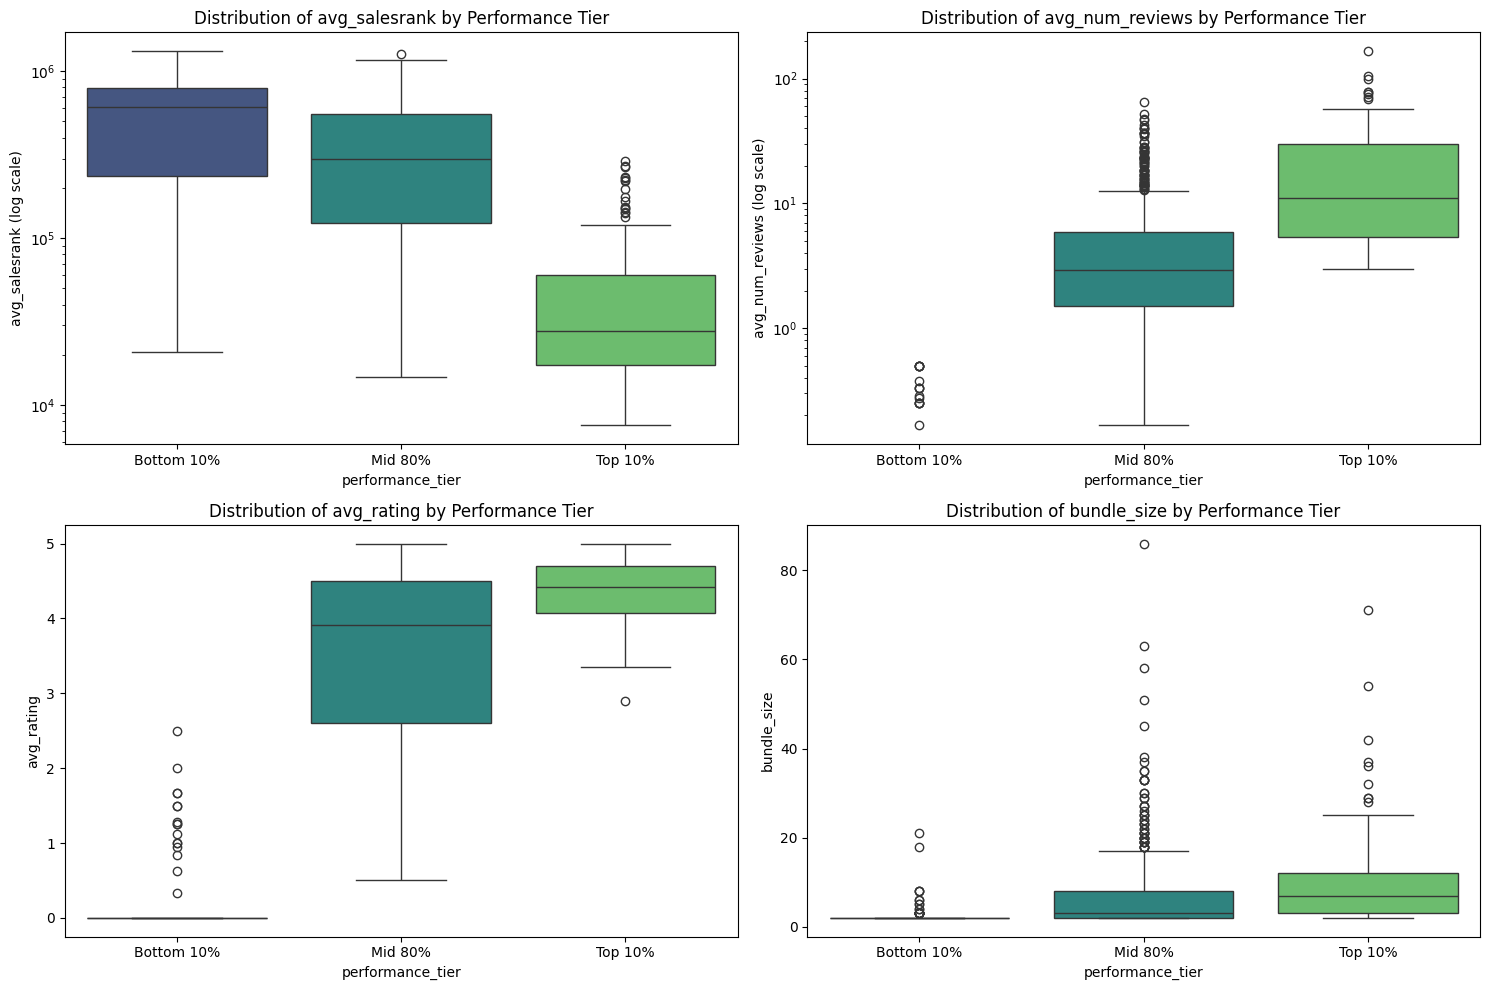


Median Feature Values by Performance Tier:
                  avg_salesrank  avg_num_reviews  avg_rating  bundle_size
performance_tier                                                         
Bottom 10%        607866.000000         0.000000    0.000000          2.0
Mid 80%           298097.461538         2.923077    3.909091          3.0
Top 10%            27890.500000        11.000000    4.422535          7.0


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("\n--- Characterizing Bundle Performance Tiers ---")

# Define quantiles for segmentation
low_quantile = df_bundles['revenue_score'].quantile(0.10)
high_quantile = df_bundles['revenue_score'].quantile(0.90)

# Create performance tier category
def assign_tier(score):
    if score <= low_quantile:
        return 'Bottom 10%'
    elif score >= high_quantile:
        return 'Top 10%'
    else:
        return 'Mid 80%'

df_bundles['performance_tier'] = df_bundles['revenue_score'].apply(assign_tier)

# Features to compare across tiers
features_to_compare = ['avg_salesrank', 'avg_num_reviews', 'avg_rating', 'bundle_size']
tier_order = ['Bottom 10%', 'Mid 80%', 'Top 10%']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_compare):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_bundles, x='performance_tier', y=feature, order=tier_order, palette='viridis')
    plt.title(f'Distribution of {feature} by Performance Tier')
    # Optional: Use log scale for highly skewed features
    if feature in ['avg_salesrank', 'avg_num_reviews']:
         plt.yscale('log')
         plt.ylabel(f'{feature} (log scale)')

plt.tight_layout()
plt.savefig(BASE + 'bundle_performance_tiers.png')
plt.show()

# Display median values per tier for comparison
print("\nMedian Feature Values by Performance Tier:")
print(df_bundles.groupby('performance_tier')[features_to_compare].median().reindex(tier_order))


--- Category Composition of Bundles ---
Calculating category info for bundles...
Category info added.

Category Info for Top 5 Bundles:
     revenue_score dominant_category  num_categories  category_diversity
531       0.018024             Music               1            0.125000
265       0.013610             Video               2            0.142857
39        0.008968             Video               1            0.083333
364       0.005680             Music               2            0.181818
316       0.005150             Video               1            0.250000


/var/folders/4q/_v913tvd0cl08n5b85ff8b6r0000gn/T/ipykernel_54805/3159113879.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='dominant_category', data=plot_data_cat,


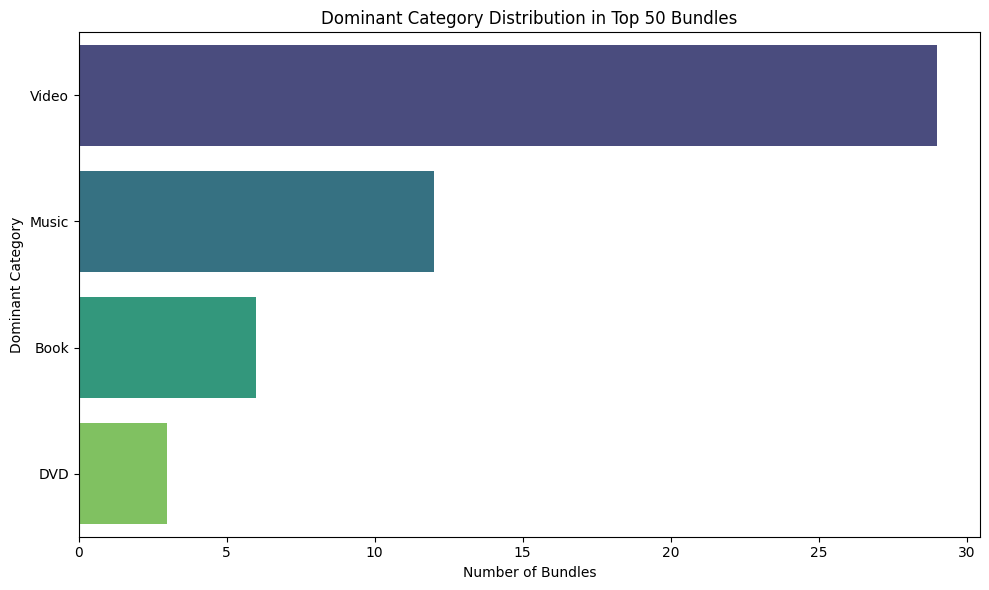

In [22]:
import pandas as pd
import matplotlib.pyplot as plt # Added import
import seaborn as sns # Added import

print("\n--- Category Composition of Bundles ---")

# Ensure product_data_clean has 'ASIN' and 'group' and required variables exist
if 'product_data_clean' not in locals() or 'df_bundles' not in locals():
     print("Error: Required DataFrames ('product_data_clean', 'df_bundles') not found.")
elif 'group' not in product_data_clean.columns:
    print("Warning: 'group' column not found in product_data_clean. Skipping category analysis.")
else:
    # Create a mapping from ASIN to group (category)
    # Ensure we handle potential NaNs in the 'group' column itself when creating the dict
    asin_to_group = product_data_clean.dropna(subset=['group']).set_index('ASIN')['group'].to_dict()

    # Function to get category info for a list of ASINs in a bundle
    def get_bundle_category_info(asin_list):
        # Get groups using the map, returns None if ASIN not in map OR group was NaN
        groups_raw = [asin_to_group.get(asin) for asin in asin_list]
        # <<< FIX: Filter out None values explicitly >>>
        groups = [g for g in groups_raw if g is not None]

        if not groups:
            # Handle case where no known categories exist for the bundle
            return pd.Series({'dominant_category': 'Unknown', 'num_categories': 0, 'category_diversity': 0.0})

        groups_series = pd.Series(groups)
        dominant = groups_series.mode()
        # Handle cases where mode returns multiple values (take the first one alphabetically for consistency)
        dominant_category = sorted(dominant.tolist())[0] if not dominant.empty else 'Multiple/Unknown' # Made mode selection deterministic
        num_unique = groups_series.nunique()
        # Ensure len(groups) is used here, not len(asin_list), for accurate diversity of known categories
        diversity = num_unique / len(groups) if len(groups) > 0 else 0.0
        return pd.Series({'dominant_category': dominant_category, 'num_categories': num_unique, 'category_diversity': diversity})

    # Apply the function to get category info for each bundle
    if 'ASIN_list' not in df_bundles.columns:
        print("Warning: 'ASIN_list' column not found in df_bundles. Cannot perform category analysis.")
    else:
        # Ensure we don't add duplicate columns if run multiple times
        cols_to_add = ['dominant_category', 'num_categories', 'category_diversity']
        df_bundles = df_bundles.drop(columns=cols_to_add, errors='ignore')
        
        print("Calculating category info for bundles...")
        category_info = df_bundles['ASIN_list'].apply(get_bundle_category_info)
        df_bundles = pd.concat([df_bundles, category_info], axis=1)
        print("Category info added.")

        # Re-sort top_bundles including the new columns
        # Ensure top_bundles is redefined based on the updated df_bundles
        if 'top_bundles' in locals():
             top_bundles = df_bundles.sort_values(by='revenue_score', ascending=False)
        else:
             # Define top_bundles if it doesn't exist yet
             top_bundles = df_bundles.sort_values(by='revenue_score', ascending=False)


        # Analyze top 5 bundles' categories
        print("\nCategory Info for Top 5 Bundles:")
        # Check if the columns were added successfully before printing
        if all(col in top_bundles.columns for col in ['revenue_score'] + cols_to_add):
             print(top_bundles[['revenue_score', 'dominant_category', 'num_categories', 'category_diversity']].head().to_string())
        else:
             print("Warning: Category columns not found in top_bundles.")


        # Visualize dominant categories in Top 50 bundles (or adjust N)
        if 'dominant_category' in top_bundles.columns:
            n_top_for_viz = 50
            # Ensure we don't try to plot more bundles than exist
            n_top_for_viz = min(n_top_for_viz, len(top_bundles))
            
            # Temporary dataframe for plotting to avoid modifying top_bundles
            plot_data_cat = top_bundles.head(n_top_for_viz)

            if not plot_data_cat.empty:
                plt.figure(figsize=(10, max(6, len(plot_data_cat['dominant_category'].unique()) * 0.3))) # Dynamic height
                
                # Calculate order based on counts within the plotted data
                order = plot_data_cat['dominant_category'].value_counts().index
                
                sns.countplot(y='dominant_category', data=plot_data_cat,
                              order=order,
                              palette='viridis')
                plt.title(f'Dominant Category Distribution in Top {n_top_for_viz} Bundles')
                plt.xlabel('Number of Bundles')
                plt.ylabel('Dominant Category')
                plt.tight_layout()
                # Ensure BASE path exists or handle error
                try:
                    plt.savefig(BASE + 'top_bundles_category_distribution.png')
                except NameError:
                    print("Warning: 'BASE' path variable not defined. Plot not saved.")
                plt.show()
            else:
                 print("No data available for category visualization.")
        else:
            print("Warning: 'dominant_category' column not found. Skipping visualization.")


--- Revenue Score vs. Key Features ---


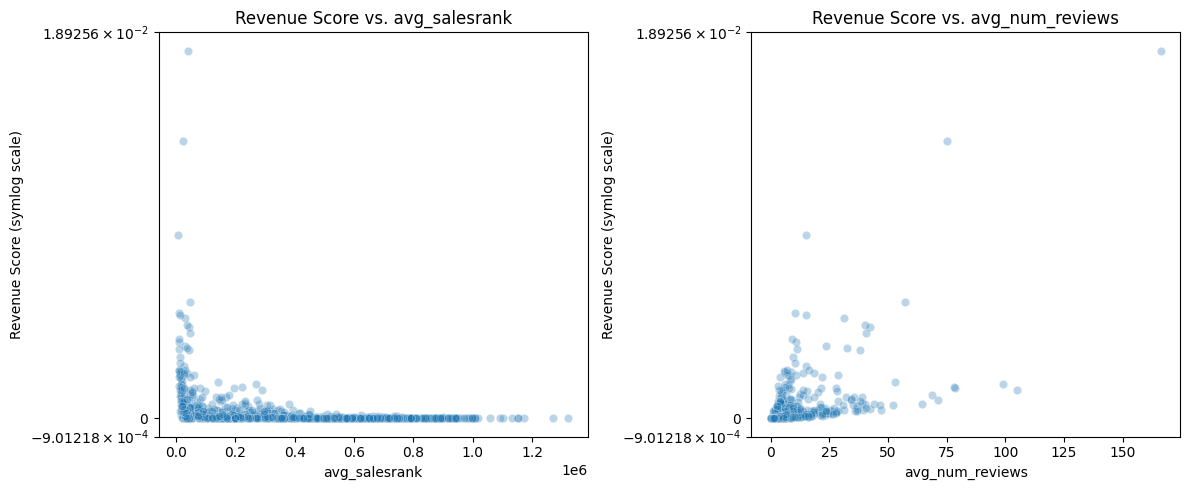

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Revenue Score vs. Key Features ---")

# Identify top 2 most important features (adjust if needed)
# Ensure importance_df exists from previous cells
if 'importance_df' in locals():
    top_features = importance_df['Feature'].head(2).tolist()
else:
    # Fallback if importance_df wasn't created or isn't available
    print("Warning: importance_df not found. Using default features for plotting.")
    top_features = ['avg_salesrank', 'avg_num_reviews'] # Default guess


plt.figure(figsize=(12, 5))
for i, feature in enumerate(top_features):
    if feature in df_bundles.columns:
        plt.subplot(1, len(top_features), i + 1)
        sns.scatterplot(data=df_bundles, x=feature, y='revenue_score', alpha=0.3)
        plt.title(f'Revenue Score vs. {feature}')

        try:
            plt.yscale('symlog')
            plt.ylabel('Revenue Score (symlog scale)')
        except Exception as e:
             print(f"Could not apply log scale to revenue_score: {e}")
             plt.ylabel('Revenue Score') # Fallback

    else:
         print(f"Warning: Feature '{feature}' not found in df_bundles.")


plt.tight_layout()
plt.savefig(BASE + 'revenue_score_vs_features.png')
plt.show()